# Code PLNE, Métaheuristique et Heuristique

## Création des villes
Dans ce processus, les villes sont générées de manière aléatoire et représentées sous forme de listes adjacentes. Pour chacune, on calcule les distances qui les séparent et on détermine leur position. Cela permet de modéliser efficacement le réseau de villes avec leurs relations spatiales.

In [5]:
def createcity(nbr, tempsmax, seed):
    random.seed(seed)
    city = [(random.randint(0, tempsmax), random.randint(0, tempsmax)) for _ in range(nbr)]
    tempo = np.zeros((nbr, nbr))
    for i in range(nbr):
        for j in range(nbr):
            if i != j:
                tempo[i][j] = round(math.sqrt((city[i][0] - city[j][0])**2 + (city[i][1] - city[j][1])**2))
    
    return city, tempo

## Programmation linéaire
Pour le solveur, nous utilisons la programmation linéaire en nombres entiers (PLNE) et définissons deux variables : l'une pour représenter les distances entre chaque paire de villes et l'autre pour gérer les sous-tournées. Cette approche permet d'optimiser le chemin tout en évitant les boucles internes indésirables.

In [ ]:
def plne(nbr,k):
    prob = LpProblem("vrptw", LpMinimize)
    
    x = LpVariable.dicts("x", [(i, j) for i in range(nbr) for j in range(nbr) if i != j], cat='Binary')
    u = LpVariable.dicts('u', range(nbr), 0, nbr - 1, LpInteger)

    prob += lpSum(tempo[i][j] * x[(i, j)] for i in range(nbr) for j in range(nbr) if i != j)
    # Contrainte 1 : Départ et arrivé au dépot
    for k_index in range(nbr):
        cam = 1 if k_index != 0 else k 
        prob += lpSum([x[(i, k_index)] for i in range(nbr) if i != k_index]) == cam
        prob += lpSum([x[(k_index, j)] for j in range(nbr) if j != k_index]) == cam
    # Contrainte 2 : Eviter les sous-tours
    N = len(city) / k
    for i in range(1, nbr): 
        for j in range(1, nbr):
            if i != j:
                prob += u[i] - u[j] <= (N) * (1 - x[(i, j)]) - 1
    # Contrainte 3 : fenetre de temps
    deb = [0] * nbr 
    end = [500] * nbr 

    for i in range(nbr):
        prob += lpSum([x[(i, j)] for j in range(nbr) if i != j]) * deb[i] <= u[i]
        prob += u[i] <= lpSum([x[(i, j)] for j in range(nbr) if i != j]) * end[i]
    
    prob.solve()
    print(LpStatus[prob.status])

## Solution initiale et fonctions 
La solution initiale est générée aléatoirement en répartissant les clients de manière équilibrée entre chaque tournée. Des fonctions sont utilisées pour calculer le coût total de la tournée (temps de parcours) et pour vérifier si une tournée a déjà été effectuée par un autre camion ou par le même.

In [ ]:
def calculer_cout_total(solution, tempo): ## Calcul du total des temps de parcours
    cout = 0
    for route in solution:
        if route:
            cout += tempo[0][route[0]]
            for i in range(len(route) - 1):
                cout += tempo[route[i]][route[i + 1]]
            cout += tempo[route[-1]][0]
    return cout

def est_tournee_valide(tournee): ## Vérifie si la tournée a déjà été effectué
    return tournee[0] == 0 and tournee[-1] == 0

def initialiser_solution(k, nbr): ## Solution initiale en rand
    clients = list(range(1, nbr))
    random.shuffle(clients)
    tournées = [[] for _ in range(k)]
    
    for i, client in enumerate(clients):
        tournées[i % k].append(client)

    for i in range(k):
        tournées[i] = [0] + tournées[i] + [0]

    while any(len(tournee) == 2 for tournee in tournées):
        for i in range(k):
            if len(tournées[i]) == 2:
                for j in range(k):
                    if len(tournées[j]) > 2:
                        client_a_deplacer = tournées[j].pop(1)
                        tournées[i].insert(1, client_a_deplacer)
                        break

    return tournées

## Heuristique
Pour l'heuristique, nous avons opté pour la méthode de voisinage. Cette approche permet d'améliorer progressivement la solution en explorant les solutions voisines afin de minimiser le coût total et d'optimiser la répartition des tournées.

In [7]:
def echanger_clients(route1, route2):
    if len(route1) > 2 and len(route2) > 2:
        idx1 = random.randint(1, len(route1) - 2) 
        idx2 = random.randint(1, len(route2) - 2) # idx1/2 retire le dépot
        route1[idx1], route2[idx2] = route2[idx2], route1[idx1]

## Métaheuristique
Pour la métaheuristique, nous avons choisi d'appliquer la recherche tabou. Cette méthode permet d'explorer l'espace des solutions de manière approfondie en évitant de revisiter des solutions déjà explorées récemment, ce qui aide à échapper aux optima locaux et à améliorer la qualité de la solution globale.

In [ ]:
def recherche_tabou_vrp(tempo, k):
    n = len(tempo)
    taille_tabou = max(30, 10 * len(str(n))-1 + k)
    nb_iterations = min(3000, 10 * n)
    meilleure_solution = initialiser_solution(k, n)
    meilleur_cout = calculer_cout_total(meilleure_solution, tempo)
    solution_actuelle = copy.deepcopy(meilleure_solution)
    liste_tabou = []

    for iteration in range(nb_iterations):
        voisinage = []

        for i in range(k):
            for j in range(i + 1, k):
                voisin = copy.deepcopy(solution_actuelle)
                echanger_clients(voisin[i], voisin[j])
                
                if all(est_tournee_valide(route) for route in voisin):
                    if voisin not in liste_tabou:
                        voisinage.append(voisin)

        meilleur_voisin = None
        cout_meilleur_voisin = float('inf')

        for voisin in voisinage:
            cout = calculer_cout_total(voisin, tempo)
            if cout < cout_meilleur_voisin:
                meilleur_voisin = voisin
                cout_meilleur_voisin = cout

        if meilleur_voisin is not None:
            solution_actuelle = meilleur_voisin
            cout_actuel = cout_meilleur_voisin

            if cout_actuel < meilleur_cout:
                meilleure_solution = solution_actuelle
                meilleur_cout = cout_actuel

        liste_tabou.append(copy.deepcopy(solution_actuelle))
        if len(liste_tabou) > taille_tabou:
            liste_tabou.pop(0)

    return meilleure_solution, meilleur_cout

## Multistart
Nous avons décidé d'utiliser la méthode multistart pour éviter les optima locaux. Cette approche consiste à lancer plusieurs recherches à partir de solutions initiales différentes, ce qui permet d'explorer un plus large éventail de solutions et d'augmenter les chances d'atteindre un optimum global.

In [ ]:
def best_soluce():
    meilleure_solution, meilleur_cout = recherche_tabou_vrp(tempo, k)
    L = [meilleure_solution, meilleur_cout]
    if nbr >= 10000:
        iterations = 100
    elif nbr >= 1000:
        iterations = 50
    elif nbr >= 120:
        iterations = 20
    else:
        iterations = 10
        return L
    i = 0
    iterations = 10 #test
    while i < iterations:
        print(i)
        meilleure_solution, meilleur_cout = recherche_tabou_vrp(tempo, k)
        if meilleur_cout < L[1]:
            L = [meilleure_solution, meilleur_cout]
            i = 0
        else:
            i+=1
    best_soluce_print(L)

## Affichage des villes et des parcours de chaques camions avec le solveur
Affichage d'un graphique les tournées des camions

In [ ]:
def plneprint(x):
    aretes = [(i, j) for i in range(nbr) for j in range(nbr) if i != j and value(x[(i, j)]) != 0]

    tours = suivant(0,aretes)
    tours = [[e] for e in tours]

    for t in tours:
        while t[-1][1] != 0:
            t.append(suivant(t[-1][1],aretes)[-1])

    for camions,t in enumerate(tours):
        print(f"Camion {camions+1} :",' -> '.join([f"Ville {a}" for a, b in t] + ['Ville 0 (Dépot)']))

    totalTime = 0
    for t in tours:
        time = 0
        for i in range(len(t)):
            time += tempo[t[i][0], t[i][1]]
        if time > totalTime:
            totalTime = time
    print("Temps total en minute:", totalTime)
    print("Temps total en heure:", totalTime/60)

    colors = [np.random.rand(3) for _ in range(len(tours))]
    for t, c in zip(tours, colors):
        for a, b in t:
            p1, p2 = city[a], city[b]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=c)

    for i, p in enumerate(city):
        plt.plot(p[0], p[1], 'o')
        label = 'Dépot' if i == 0 else f"Ville {i}"
        plt.text(p[0] + .01, p[1], label, horizontalalignment='left', verticalalignment='center')

    plt.title(f'{k} camions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

## Affichage des villes et des parcours de chaques camions avec la métaheuristique
Affichage d'un graphique les tournées des camions

In [ ]:
def best_soluce_print(L):
    print("parfait")
    meilleure_solution, meilleur_cout = L
    print("Meilleure solution trouvée:")
    for i, tournee in enumerate(meilleure_solution):
        print(f"Camion {i+1}:", ' -> '.join([f"Ville {a}" for a in tournee] + ['Ville 0 (Dépot)']))
    print("Coût total:", meilleur_cout)

    colors = [np.random.rand(3) for _ in range(len(meilleure_solution))]
    for t, c in zip(meilleure_solution, colors):
        for i in range(len(t) - 1):
            p1, p2 = city[t[i]], city[t[i + 1]]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=c)

    for i, p in enumerate(city):
        plt.plot(p[0], p[1], 'o')
        label = 'Dépot' if i == 0 else f"Ville {i}"
        plt.text(p[0] + .01, p[1], label, horizontalalignment='left', verticalalignment='center')
        
    max_duration = 0
    for tournee in meilleure_solution:
        duration = 0
        for i in range(len(tournee) - 1):
            duration += tempo[tournee[i]][tournee[i + 1]]
        if duration > max_duration:
            max_duration = duration
    print(f"Temps demandé : {time_window}")
    print(f"Temps total du dernier camion arrivé: {max_duration}")
    if(max_duration > time_window):
        print(f"La fenêtre de temps est dépassée de {max_duration - time_window} minutes")
    else:
        print(f"La fenêtre de temps est respectée : {time_window - max_duration} minutes restantes")


    plt.title(f'{k} camions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

## Code complet

In [ ]:
import numpy as np
import random
import math
import copy
from pulp import *
from matplotlib import pyplot as plt
import time

def createcity(nbr, tempsmax, seed):
    random.seed(seed)
    city = [(random.randint(0, tempsmax), random.randint(0, tempsmax)) for _ in range(nbr)]
    tempo = np.zeros((nbr, nbr))
    for i in range(nbr):
        for j in range(nbr):
            if i != j:
                tempo[i][j] = round(math.sqrt((city[i][0] - city[j][0])**2 + (city[i][1] - city[j][1])**2))
    
    return city, tempo

def calculer_cout_total(solution, tempo):
    cout = 0
    for route in solution:
        if route:
            cout += tempo[0][route[0]]
            for i in range(len(route) - 1):
                cout += tempo[route[i]][route[i + 1]]
            cout += tempo[route[-1]][0]
    return cout

def echanger_clients(route1, route2):
    if len(route1) > 2 and len(route2) > 2:
        idx1 = random.randint(1, len(route1) - 2)
        idx2 = random.randint(1, len(route2) - 2)
        route1[idx1], route2[idx2] = route2[idx2], route1[idx1]

def est_tournee_valide(tournee):
    return tournee[0] == 0 and tournee[-1] == 0

def initialiser_solution(k, nbr):
    clients = list(range(1, nbr))
    random.shuffle(clients)
    tournées = [[] for _ in range(k)]
    
    for i, client in enumerate(clients):
        tournées[i % k].append(client)

    for i in range(k):
        tournées[i] = [0] + tournées[i] + [0]

    while any(len(tournee) == 2 for tournee in tournées):
        for i in range(k):
            if len(tournées[i]) == 2:
                for j in range(k):
                    if len(tournées[j]) > 2:
                        client_a_deplacer = tournées[j].pop(1)
                        tournées[i].insert(1, client_a_deplacer)
                        break

    return tournées

def recherche_tabou_vrp(tempo, k):
    n = len(tempo)
    taille_tabou = max(30, 10 * len(str(n))-1 + k)
    nb_iterations = 10#test min(3000, 10 * n)
    meilleure_solution = initialiser_solution(k, n)
    meilleur_cout = calculer_cout_total(meilleure_solution, tempo)
    solution_actuelle = copy.deepcopy(meilleure_solution)
    liste_tabou = []

    for iteration in range(nb_iterations):
        voisinage = []

        for i in range(k):
            for j in range(i + 1, k):
                voisin = copy.deepcopy(solution_actuelle)
                echanger_clients(voisin[i], voisin[j])
                
                if all(est_tournee_valide(route) for route in voisin):
                    if voisin not in liste_tabou:
                        voisinage.append(voisin)

        meilleur_voisin = None
        cout_meilleur_voisin = float('inf')

        for voisin in voisinage:
            cout = calculer_cout_total(voisin, tempo)
            if cout < cout_meilleur_voisin:
                meilleur_voisin = voisin
                cout_meilleur_voisin = cout

        if meilleur_voisin is not None:
            solution_actuelle = meilleur_voisin
            cout_actuel = cout_meilleur_voisin

            if cout_actuel < meilleur_cout:
                meilleure_solution = solution_actuelle
                meilleur_cout = cout_actuel

        liste_tabou.append(copy.deepcopy(solution_actuelle))
        if len(liste_tabou) > taille_tabou:
            liste_tabou.pop(0)

    return meilleure_solution, meilleur_cout

def best_soluce():
    meilleure_solution, meilleur_cout = recherche_tabou_vrp(tempo, k)
    L = [meilleure_solution, meilleur_cout]
    if nbr >= 10000:
        iterations = 100
    elif nbr >= 1000:
        iterations = 50
    elif nbr >= 120:
        iterations = 20
    else:
        iterations = 10
        return L
    i = 0
    iterations = 10 #test
    while i < iterations:
        print(i)
        meilleure_solution, meilleur_cout = recherche_tabou_vrp(tempo, k)
        if meilleur_cout < L[1]:
            L = [meilleure_solution, meilleur_cout]
            i = 0
        else:
            i+=1
    best_soluce_print(L)

def best_soluce_print(L):
    print("parfait")
    meilleure_solution, meilleur_cout = L
    print("Meilleure solution trouvée:")
    for i, tournee in enumerate(meilleure_solution):
        print(f"Camion {i+1}:", ' -> '.join([f"Ville {a}" for a in tournee] + ['Ville 0 (Dépot)']))
    print("Coût total:", meilleur_cout)

    colors = [np.random.rand(3) for _ in range(len(meilleure_solution))]
    for t, c in zip(meilleure_solution, colors):
        for i in range(len(t) - 1):
            p1, p2 = city[t[i]], city[t[i + 1]]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=c)

    for i, p in enumerate(city):
        plt.plot(p[0], p[1], 'o')
        label = 'Dépot' if i == 0 else f"Ville {i}"
        plt.text(p[0] + .01, p[1], label, horizontalalignment='left', verticalalignment='center')
        
    max_duration = 0
    for tournee in meilleure_solution:
        duration = 0
        for i in range(len(tournee) - 1):
            duration += tempo[tournee[i]][tournee[i + 1]]
        if duration > max_duration:
            max_duration = duration
    print(f"Temps demandé : {time_window}")
    print(f"Temps total du dernier camion arrivé: {max_duration}")
    if(max_duration > time_window):
        print(f"La fenêtre de temps est dépassée de {max_duration - time_window} minutes")
    else:
        print(f"La fenêtre de temps est respectée : {time_window - max_duration} minutes restantes")


    plt.title(f'{k} camions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    

def plne(nbr,k):
    prob = LpProblem("vrptw", LpMinimize)
    
    x = LpVariable.dicts("x", [(i, j) for i in range(nbr) for j in range(nbr) if i != j], cat='Binary')
    u = LpVariable.dicts('u', range(nbr), 0, nbr - 1, LpInteger)

    prob += lpSum(tempo[i][j] * x[(i, j)] for i in range(nbr) for j in range(nbr) if i != j)

    for k_index in range(nbr):
        cam = 1 if k_index != 0 else k 
        prob += lpSum([x[(i, k_index)] for i in range(nbr) if i != k_index]) == cam
        prob += lpSum([x[(k_index, j)] for j in range(nbr) if j != k_index]) == cam

    N = len(city) / k
    for i in range(1, nbr): 
        for j in range(1, nbr):
            if i != j:
                prob += u[i] - u[j] <= (N) * (1 - x[(i, j)]) - 1

    deb = [0] * nbr 
    end = [500] * nbr 

    for i in range(nbr):
        prob += lpSum([x[(i, j)] for j in range(nbr) if i != j]) * deb[i] <= u[i]
        prob += u[i] <= lpSum([x[(i, j)] for j in range(nbr) if i != j]) * end[i]
    
    prob.solve()
    print(LpStatus[prob.status])
    plneprint(x)
    
def suivant(parent,aretes):
        edges = [e for e in aretes if e[0] == parent]
        for e in edges:
            aretes.remove(e)
        return edges    
    
def plneprint(x):
    aretes = [(i, j) for i in range(nbr) for j in range(nbr) if i != j and value(x[(i, j)]) != 0]

    tours = suivant(0,aretes)
    tours = [[e] for e in tours]

    for t in tours:
        while t[-1][1] != 0:
            t.append(suivant(t[-1][1],aretes)[-1])

    for camions,t in enumerate(tours):
        print(f"Camion {camions+1} :",' -> '.join([f"Ville {a}" for a, b in t] + ['Ville 0 (Dépot)']))

    totalTime = 0
    for t in tours:
        time = 0
        for i in range(len(t)):
            time += tempo[t[i][0], t[i][1]]
        if time > totalTime:
            totalTime = time
    print("Temps total en minute:", totalTime)
    print("Temps total en heure:", totalTime/60)

    colors = [np.random.rand(3) for _ in range(len(tours))]
    for t, c in zip(tours, colors):
        for a, b in t:
            p1, p2 = city[a], city[b]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=c)

    for i, p in enumerate(city):
        plt.plot(p[0], p[1], 'o')
        label = 'Dépot' if i == 0 else f"Ville {i}"
        plt.text(p[0] + .01, p[1], label, horizontalalignment='left', verticalalignment='center')

    plt.title(f'{k} camions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    

if __name__ == "__main__":
    nbr = int(input("Entrez le nombre de clients: "))
    k = int(input("Entrez le nombre de véhicules: "))
    tw = input("Indiquez la fenêtre de temps: ")
    try:
        hours, minutes = map(int, tw.split('h'))
        time_window = hours * 60 + minutes
    except ValueError:
        print("Format de la fenêtre de temps invalide. Utilisez le format --h--.")
        exit(1)
    tempsmax = 500
    seed = 3
    city, tempo = createcity(nbr, tempsmax, seed)
    if nbr <= 10 and k <= 3:
        plne(nbr, k)
    else: 
        best_soluce()

# Statistiques

## Détermination de la taille tabou
Grâce à l'analyse des graphes, nous avons déterminé la taille de la liste tabou en utilisant la formule suivante : taille_tabou = max(30, 10 * len(str(n)) - 1 + k). Par ailleurs, le nombre d'itérations de la recherche tabou a été ajusté en fonction de l'analyse des graphes, avec la formule : nb_iterations = (3000, 10 * n).

### Avec 10 000 villes et 10 camions
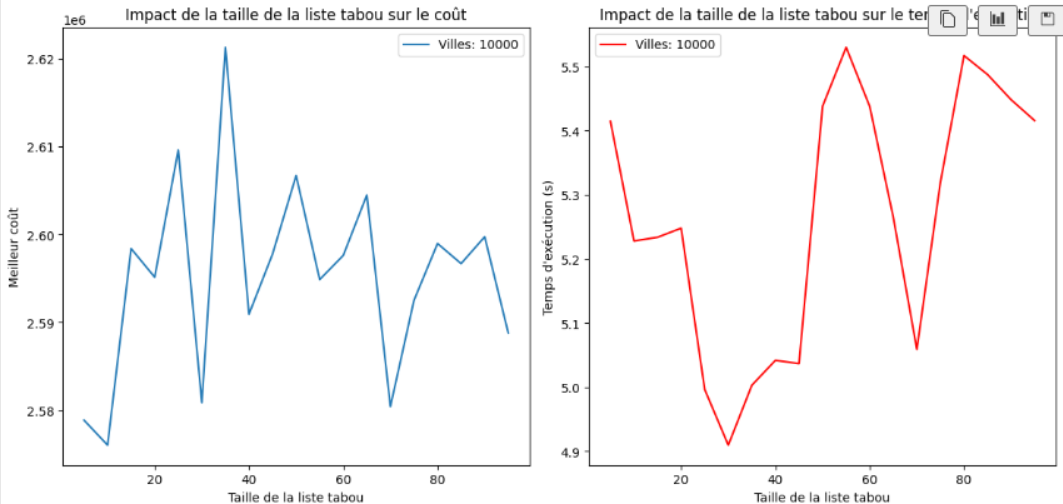
### Avec 10 000 villes et 15 camions
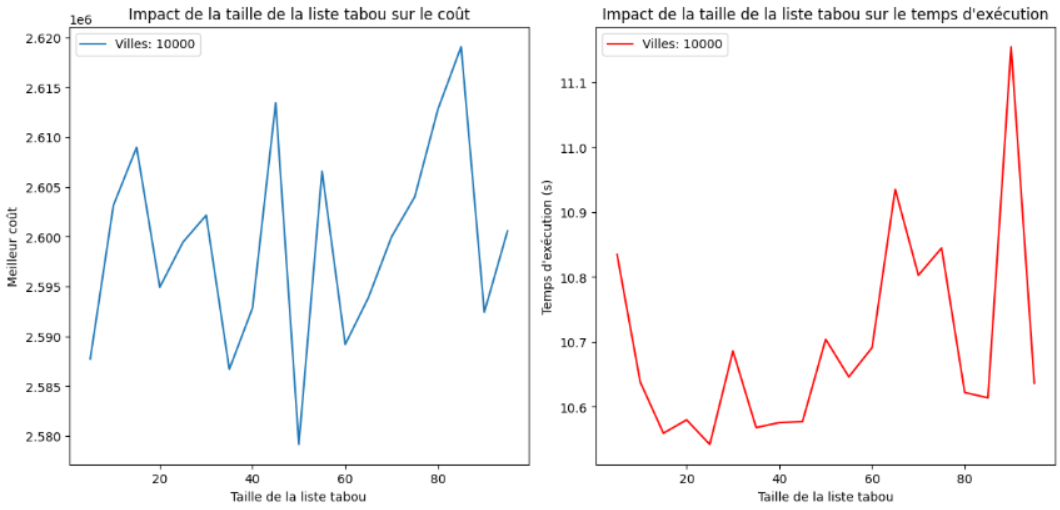

## Détermination du nombre d'itération

### Le cout en fonction du nombre d'itération de la recherche tabou avec 1000 villes et 15 camions
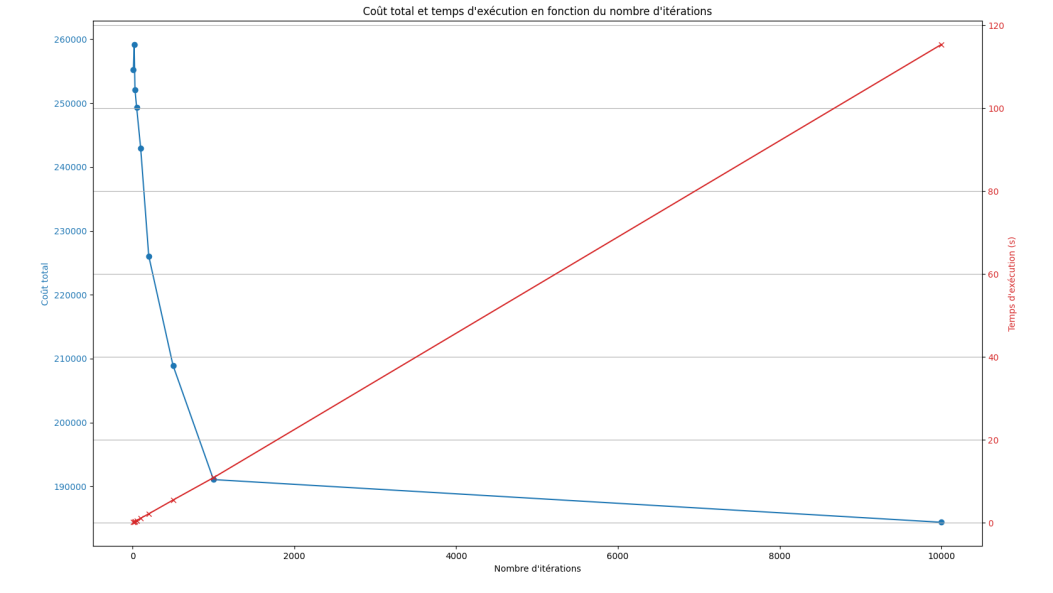
### Le cout en fonction du nombre d'itération de la recherche tabou avec 10 000 villes et 15 camions
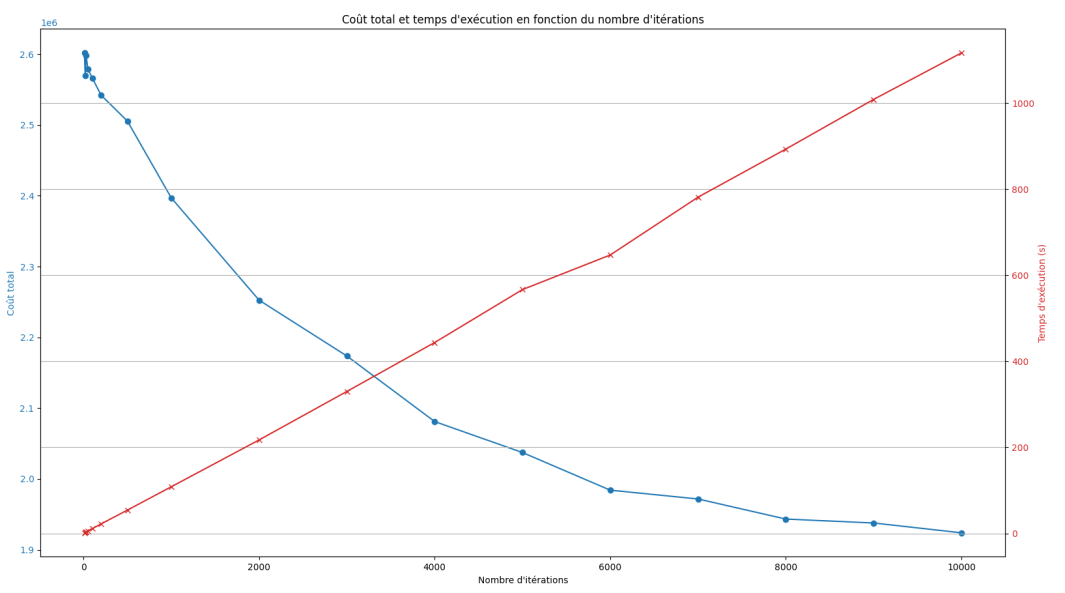

### Le cout en fonction de k camions
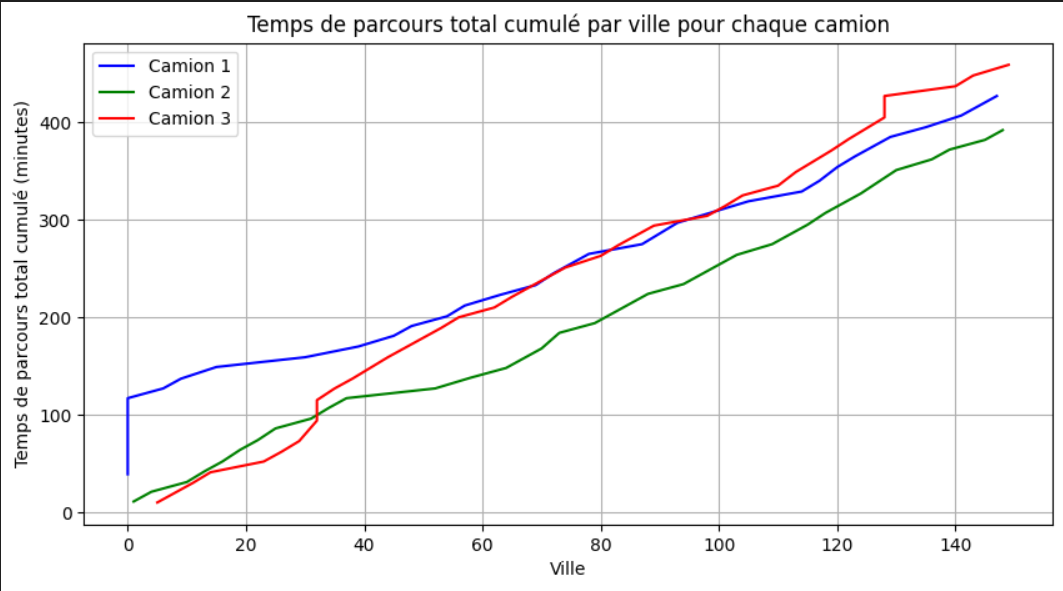